In [3]:
import pandas as pd
import numpy as np

# Load the cleaned CSVs
baseline_df = pd.read_csv("/content/Baseline_us-west-1_20250531_004119.csv", skiprows=1)
cloudflare_df = pd.read_csv("/content/Cloudflare_One_us-west-1_20250603_200259.csv", skiprows=1)

# Label source
baseline_df['Source'] = 'Baseline'
cloudflare_df['Source'] = 'Cloudflare WARP'

# Combine
df = pd.concat([baseline_df, cloudflare_df], ignore_index=True)

# Rename columns
df = df.rename(columns={
    "METRICS": "metric_1",
    "Unnamed: 4": "metric_2",
    "Unnamed: 5": "metric_3",
    "Unnamed: 6": "metric_4",
    "Unnamed: 7": "metric_5",
    "Unnamed: 8": "metric_6"
})

def clean_metric(val):
    if isinstance(val, str):
        val = val.replace("ms", "").replace("s", "").strip()
        if val == "NA" or val == "":
            return np.nan
        try:
            return float(val)
        except:
            return np.nan
    return val

# Clean and compute features
metric_cols = ['metric_1', 'metric_2', 'metric_3', 'metric_4', 'metric_5', 'metric_6']
for col in metric_cols:
    df[col] = df[col].apply(clean_metric)

df["metric_mean"] = df[metric_cols].mean(axis=1).round(3)
df["metric_std"] = df[metric_cols].std(axis=1).round(3)
df["test_failed"] = df[metric_cols].isnull().all(axis=1)

In [4]:
clean_df = df[df["metric_mean"] < 5000]

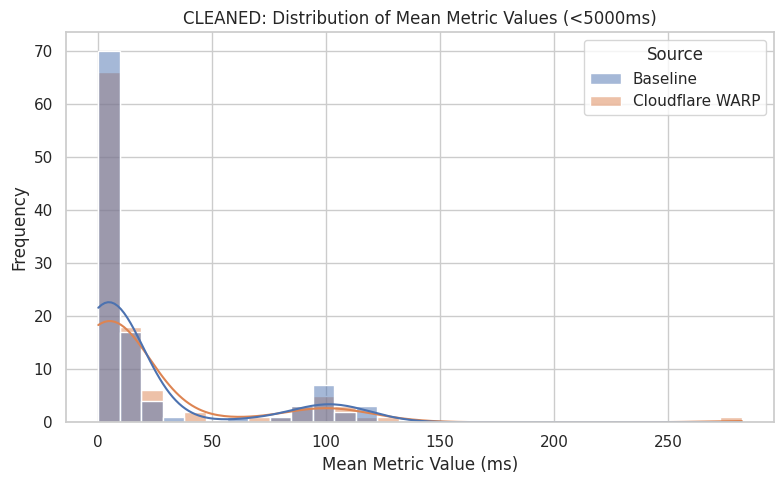

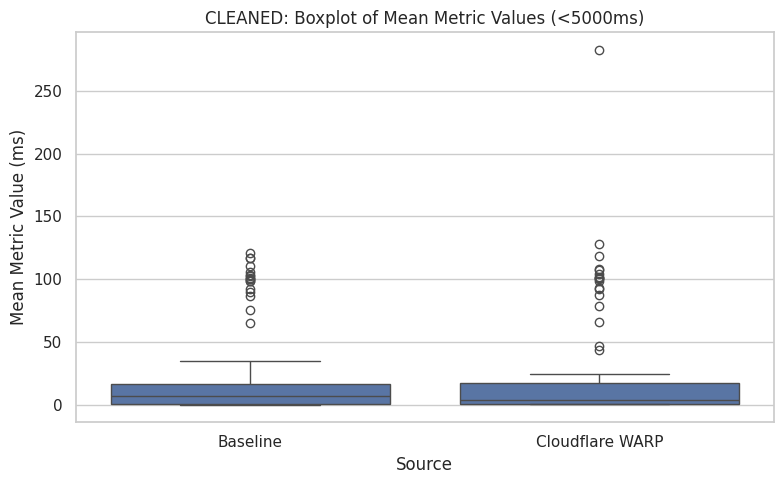

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=clean_df, x="metric_mean", hue="Source", bins=30, kde=True)
plt.title("CLEANED: Distribution of Mean Metric Values (<5000ms)")
plt.xlabel("Mean Metric Value (ms)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=clean_df, x="Source", y="metric_mean")
plt.title("CLEANED: Boxplot of Mean Metric Values (<5000ms)")
plt.ylabel("Mean Metric Value (ms)")
plt.tight_layout()
plt.show()

Context:
This histogram shows how latency values (after removing outliers >5000ms) are distributed for Baseline and Cloudflare WARP.

Both services have a strong left-skew, with most latency values under 20ms.

Baseline has more dense clusters around lower values, while Cloudflare has a slightly wider spread.
Purpose: Identify if one provider consistently has lower average latency


This histogram shows how latency values (after removing outliers >5000ms) are distributed for Baseline and Cloudflare WARP.

Both services have a strong left-skew, with most latency values under 20ms.

Baseline has more dense clusters around lower values, while Cloudflare has a slightly wider spread.
Purpose: Identify if one provider consistently has lower average latency

In [6]:
# Group Stats
group_stats = clean_df.groupby("Source")[["metric_mean", "metric_std"]].agg(["mean", "std", "min", "max", "count"])
print("📊 Grouped Summary Stats:")
print(group_stats)

📊 Grouped Summary Stats:
                metric_mean                                  metric_std  \
                       mean        std    min      max count       mean   
Source                                                                    
Baseline          20.211963  35.070983  0.029  120.975   109  20.189380   
Cloudflare WARP   21.843185  42.051868  0.055  282.457   108  23.424887   

                                                  
                       std    min      max count  
Source                                            
Baseline         37.037100  0.026  110.424    71  
Cloudflare WARP  45.616382  0.051  256.850    71  


In [8]:
# Top/Bottom Destinations
top_latency = clean_df.sort_values(by="metric_mean", ascending=False).head(10)
bottom_latency = clean_df.sort_values(by="metric_mean", ascending=True).head(10)

print("\n Top 10 High-Latency Targets:")
print(top_latency[["DESTINATION", "LOCATION", "metric_mean", "Source"]])

print("\n Top 10 Low-Latency Targets:")
print(bottom_latency[["DESTINATION", "LOCATION", "metric_mean", "Source"]])


 Top 10 High-Latency Targets:
            DESTINATION              LOCATION  metric_mean           Source
251  angolacables.co.ao            Luanda, AO      282.457  Cloudflare WARP
259   1.vn.pool.ntp.org             Hanoi, VN      128.071  Cloudflare WARP
8     1.vn.pool.ntp.org  Ho Chi Minh City, VN      120.975         Baseline
262     hurriyet.com.tr          Istanbul, TR      118.759  Cloudflare WARP
0    angolacables.co.ao            Luanda, AO      117.025         Baseline
11      hurriyet.com.tr          Istanbul, TR      116.404         Baseline
33           uol.com.br         São Paulo, BR      110.154         Baseline
284          uol.com.br         São Paulo, BR      107.858  Cloudflare WARP
260            mimos.my       Bukit Jalil, MY      106.853  Cloudflare WARP
26             emol.com          Santiago, CL      105.646         Baseline

 Top 10 Low-Latency Targets:
                     DESTINATION           LOCATION  metric_mean    Source
100  https://elobservador.co

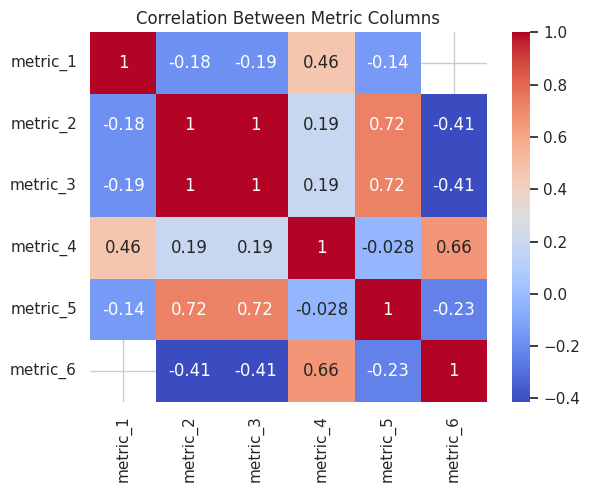

In [9]:
import seaborn as sns
corr = df[metric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Metric Columns")
plt.show()


Context:
This heatmap shows the relationship between individual metric columns.

metric_2 and metric_3 are perfectly correlated (likely duplicates).

metric_4 has some moderate correlation with metric_1 and metric_6.
Purpose: Optimize feature selection or drop redundant metrics.

<ipython-input-10-2199205319>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Country'] = clean_df['LOCATION'].str.extract(r',\s*(\w+)$')


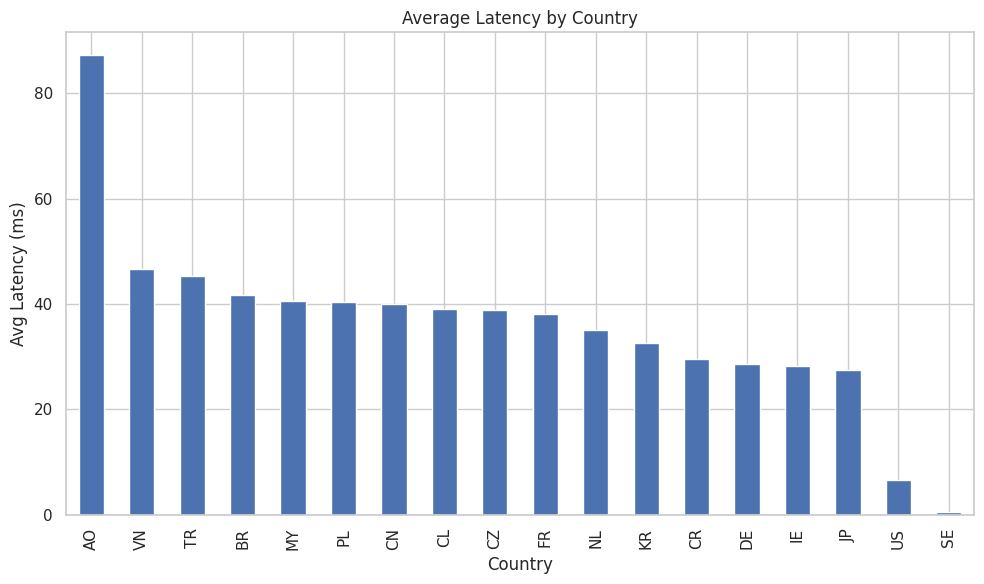

In [10]:
clean_df['Country'] = clean_df['LOCATION'].str.extract(r',\s*(\w+)$')
country_latency = clean_df.groupby("Country")["metric_mean"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
country_latency.plot(kind='bar')
plt.title("Average Latency by Country")
plt.ylabel("Avg Latency (ms)")
plt.tight_layout()
plt.show()


This bar chart displays the average latency per country, extracted from test endpoint locations.

Angola (AO) and Vietnam (VN) top the chart with the highest average latencies, indicating geographic distance or poor routing paths.

Countries like Sweden (SE) and United States (US) show the lowest latencies, likely due to better infrastructure and proximity to test clients or data centers

In [11]:
clean_df["latency_stability"] = clean_df["metric_std"] / clean_df["metric_mean"]


<ipython-input-11-2805044788>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["latency_stability"] = clean_df["metric_std"] / clean_df["metric_mean"]


<ipython-input-12-1441150871>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[features.index, "Cluster"] = kmeans.labels_


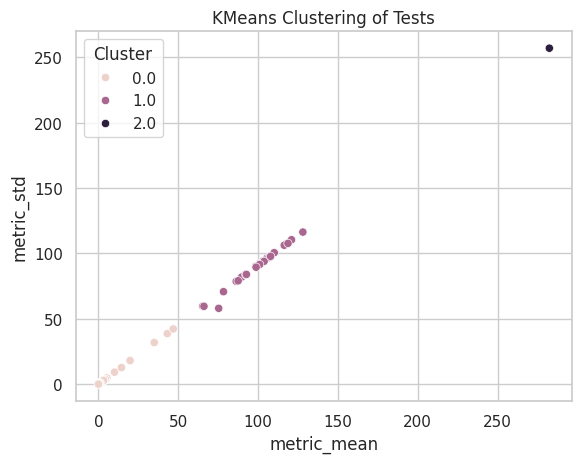

In [12]:
from sklearn.cluster import KMeans

features = clean_df[["metric_mean", "metric_std"]].dropna()
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)
clean_df.loc[features.index, "Cluster"] = kmeans.labels_

sns.scatterplot(data=clean_df, x="metric_mean", y="metric_std", hue="Cluster")
plt.title("KMeans Clustering of Tests")
plt.show()


Context:
KMeans unsupervised clustering grouped test results into 3 clusters based on mean and std deviation of latency.

Cluster 0: Low latency + low variance (best performers)

Cluster 1: Medium latency + moderate jitter

Cluster 2: High latency + high variability (worst performers)
Purpose: Segment performance profiles without manually labeling